<a href="https://colab.research.google.com/github/AshAswin/evidential_mcdo_adf_gp/blob/main/evidential_regression_toydataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
torch.manual_seed(0)
np.random.seed(0)

In [13]:
#fn1: y = sin(3x)/(3x)
mu = 0
sigma = 0.08
train_range = np.linspace(-3, 3, 100).reshape(-1,1)

# range1 = np.linspace(-3, -0.5, 50).reshape(-1,1)
# range2 = np.linspace(0.5, 3, 50).reshape(-1,1)
# train_range = np.vstack((range1,range2))

test_range = np.linspace(-5,5,100).reshape(-1,1)
function = lambda x:np.sin(3*x)/(3*x)

In [14]:
#fn2: y = 0.1x^3
# mu = 0
# sigma = 0.025
# #train_data generated from two intervals in the total range
# #train_range = np.linspace(-3, 3, 100).reshape(-1,1)
# range1 = np.linspace(-4, -1, 50).reshape(-1,1)
# range2 = np.linspace(1, 4, 50).reshape(-1,1)
# train_range = np.vstack((range1,range2))

# test_range = np.linspace(-4,4,200).reshape(-1,1)
# function = lambda x:0.1*x**3

In [15]:
#fn3: y =-(1+x)sin(1.2x)
# mu = 0
# sigma = 0.04
# #train_data generated from two intervals in the total range
# #train_range = np.linspace(-3, 3, 100).reshape(-1,1)
# range1 = np.linspace(-6, -2, 50).reshape(-1,1)
# range2 = np.linspace(2, 6, 50).reshape(-1,1)
# train_range = np.vstack((range1,range2))

# test_range = np.linspace(-6,6,200).reshape(-1,1)
# function = lambda x:-(1+x)*np.sin(1.2*x)

In [16]:
class Data():
  def __init__(self, x, func, noise={'mu':0,'sigma':1}):
    self.x = x
    self.y_gt = func(self.x)
    self.epsilon = np.random.normal(noise['mu'],noise['sigma'],np.shape(x))
    self.y = self.y_gt + self.epsilon

def plot_results(train_data,test_data, prediction, aleatoric, epistemic,\
                 limits,v_span, legend_loc, fn_samples, title='', filename='fn'):
  #Obtain Standard Deviation  
  aleatoric = np.sqrt(aleatoric)
  epistemic = np.sqrt(epistemic)
  # plot and show learning process
  fig, ax = plt.subplots(figsize=(15,10))
  plt.cla()

  aleatoric = aleatoric[:,0]
  epistemic = epistemic[:,0]#.squeeze()
  prediction = prediction[:,0]

  ax.fill_between(test_data.x.squeeze(), prediction + 2*aleatoric,\
                  prediction - 2*aleatoric, color='peachpuff',alpha=0.9,\
                  label='aleatoric')
  ax.fill_between(test_data.x.squeeze(), prediction +2*epistemic,\
                  prediction-2*epistemic, color='blue',alpha=0.2,\
                  label='epistemic')

  ax.set_title(title, fontsize=35)
  ax.set_xlabel('input', fontsize=24)
  ax.set_ylabel('output', fontsize=24)
  # ax.set_xlim(x.min,x.max)
  ax.set_xlim(limits['x'])
  ax.set_ylim(limits['y'])

  for limits in v_span:
    ax.axvspan(limits[0], limits[1], alpha=0.25, color='lightgreen',label='OOD')
  
  ax.scatter(train_data.x.squeeze(), train_data.y.squeeze(), color = "green",\
             label='train_inputs')
  ax.plot(test_data.x.squeeze(), prediction, 'g-', lw=3, label='prediction',\
          color='blue')
  ax.plot(test_data.x.squeeze(),test_data.y_gt.squeeze(),lw=3,\
          label='ground truth',color='black',linestyle='--')
  plt.legend(loc=legend_loc, prop={'size':20})
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.grid()

In [17]:

train_data = Data(train_range, function,noise={'mu':mu, 'sigma':sigma})
test_data = Data(test_range, function,noise={'mu':mu, 'sigma':sigma})

In [18]:
class EvidentialLoss(torch.nn.Module):
  def __init__(self, weight=None, size_average=True, debug=False, return_all=False):
    super(EvidentialLoss, self).__init__()
    self.debug = debug
    self.return_all_values = return_all
    self.prev_loss = 0
    self.MAX_CLAMP_VALUE = 5.0   # Max you can go is 85 because exp(86) is nan  Now exp(5.0) is 143 which is max of a,b and l

  def forward(self, inputs, targets, epoch=2000):
    targets = targets.view(-1)
    y = inputs[:,0].view(-1) #first column is mu,delta, predicted value
    a = inputs[:,1].view(-1) + 1.0 #alpha
    b = inputs[:,2].view(-1) + 0.1 #beta to avoid zero
    l = inputs[:,3].view(-1) + 1.0 #lamda

    a = torch.clamp(a, min=1.0)
    b = torch.clamp(b, min=0.1)
    l = torch.clamp(l, min=1.0)

    if self.debug:
      print("a :", a)
      print("b :", b)
      print("l :", l)

    clamped_lgamma_01 = torch.clamp(torch.lgamma(a - 0.5), max=self.MAX_CLAMP_VALUE)
    clamped_lgamma_02 = torch.clamp(torch.lgamma(a), max=self.MAX_CLAMP_VALUE)

    term1 = (torch.exp(clamped_lgamma_01))/(4 * torch.exp(clamped_lgamma_02) * l * torch.sqrt(b))
    if self.debug:
      print("term1 :", term1)
    term2 = 2 * b *(1 + l) + (2*a - 1)*l*(y - targets)**2
    if self.debug:
      print("term2 :", term2)

    J = term1 * term2
    if self.debug:
      print("J :", J)
    #Kl_divergence = torch.abs(y - targets) * (2*a + l)
    Kl_divergence = ((y - targets)**2) * (2*a + l)
    #Kl_divergence = 0.0

    if self.debug:
      print ("KL ",Kl_divergence.data.numpy())
    loss = J + min(1.0, epoch/2000)*Kl_divergence

    if self.debug:
      print ("loss :", loss.mean())


    if self.return_all_values:
      ret_loss = loss
    else:
      ret_loss = loss.mean()
    #if torch.isnan(ret_loss):
    #  ret_loss.item() = self.prev_loss + 10
    #else:
    #  self.prev_loss = ret_loss.item()

    return ret_loss


In [19]:
class EvidentialNet(torch.nn.Module):
  def __init__(self):
    super(EvidentialNet, self).__init__()
    #hidden layers
    self.hid1 = torch.nn.Linear(1,100)
    #output
    self.output = torch.nn.Linear(100,1)
    self.uncertainty = torch.nn.Linear(100,3)
    #self.output = torch.nn.Linear(100,4)

    torch.nn.init.normal_(self.hid1.weight)
    torch.nn.init.zeros_(self.hid1.bias)
    torch.nn.init.normal_(self.output.weight)
    torch.nn.init.zeros_(self.output.bias)
    torch.nn.init.normal_(self.uncertainty.weight)
    torch.nn.init.zeros_(self.uncertainty.bias)
    #can be achieved using nn.Sequential also
  def forward(self, x):
    # define how every layer is linked with each other and how computation 
    #takes place
    #Activation functions
    x_dash = torch.nn.functional.relu(self.hid1(x))
    #Do not apply activation function to the output layer
    prediction = self.output(x_dash)
    probability = torch.abs(self.uncertainty(x_dash))

    final_out = torch.cat((prediction,probability),dim=1)
    return final_out

In [20]:
def log_likelihood(y_pred, y_true, sigma):
    y_true = torch.Tensor(y_true)
    y_pred= torch.Tensor(y_pred)
    sigma = torch.Tensor(sigma)
    
    dist = torch.distributions.normal.Normal(loc=y_pred, scale=sigma)
    ll = torch.mean(dist.log_prob(y_true))
    ll = np.asscalar(ll.numpy())
    print("NLL = {}".format(-ll))
    return ll


def compute_rmse(predictions, real_values):
    assert np.all(predictions.shape == real_values.shape)
    mse = np.mean(np.square(predictions - real_values))
    rmse = np.sqrt(mse)
    print("RMSE = {}".format(rmse))
    return rmse

def explained_variance_1d(ypred,y):
    """
    Var[ypred - y] / var[y].
    https://www.quora.com/What-is-the-meaning-proportion-of-variance-explained-in-linear-regression
    """
    assert y.ndim == 1 and ypred.ndim == 1
    vary = np.var(y)
    return np.nan if vary==0 else 1 - np.var(y-ypred)/vary


def compute_explained_variance(predictions, real_values):
    """
    Computes the explained variance of prediction for each
    steering and the average of them
    """
    assert np.all(predictions.shape == real_values.shape)
    ex_variance = explained_variance_1d(predictions, real_values)
    print("EVA = {}".format(ex_variance))
    return ex_variance

In [21]:
#Inference
custom_net = EvidentialNet()
#Set to train mode/enable the train flag
custom_net = custom_net.train()

#Set hyperparameters
n_data_points = np.shape(train_data.x)[0]
batch_size = n_data_points
epochs = 20000
batch_per_epoch = n_data_points//batch_size
learning_rate = 1e-3
#Loss Function
loss_function = EvidentialLoss()
#Optimizer
optimizer = torch.optim.Adam(custom_net.parameters(), lr=learning_rate)
X = torch.Tensor(train_data.x).view(-1,1)
Y = torch.Tensor(train_data.y).view(-1,1)
for epoch in range(epochs):
  #current_batch = np.random.choice(n_data_points,batch_size,replace=False)
  #view is equivalent to reshape method
  output = custom_net(X)
  #loss to minimize the difference
  loss_fn_obj = loss_function(output, Y, epoch)
  #sets accumulated gradients to zero so that the delta calculated 
  optimizer.zero_grad() 
  #computes gradient            
  loss_fn_obj.backward()
  #x = x + learning_rate * \del x
  optimizer.step()
    
  if np.mod(epoch, 10000) == 0:
      print (loss_fn_obj)

tensor(265.6752, grad_fn=<MeanBackward0>)
tensor(0.1872, grad_fn=<MeanBackward0>)


NLL = 0.5750387907028198
RMSE = 0.39998507972195535
EVA = -0.29099910907341875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


-0.29099910907341875

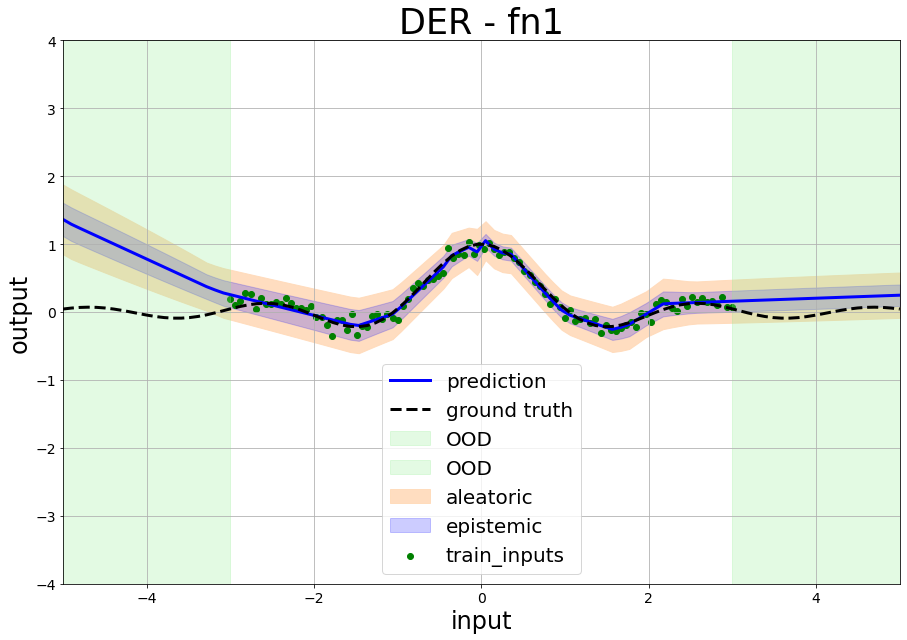

In [22]:
custom_net.eval()
x_test = torch.Tensor(test_data.x).view(-1,1)
#Picking the model corresponding to the last epoch
y_pred = custom_net(x_test)
y_pred = y_pred.detach().numpy()

mu = np.asarray(y_pred[:,0])
a = np.asarray(y_pred[:,1]) + 1.0
b = np.asarray(y_pred[:,2]) + 0.1
l = np.asarray(y_pred[:,3]) + 1.0

aleatoric = b/(a-1)
epistemic= b/((a-1)*l)
predictions = mu



plot_results(train_data,test_data, predictions.reshape(-1,1),\
             aleatoric.reshape(-1,1), epistemic.reshape(-1,1),\
              limits={"x":(-5,5),"y":(-4,4)},v_span=[(-5,-3),(3,5)],
             fn_samples=None, legend_loc='lower center',
             title='DER - fn1',filename='der_fn1.pdf')



#metrics evaluation
predictive_uncertainty = epistemic + aleatoric
log_likelihood(predictions.squeeze(), test_data.y_gt.squeeze(), np.sqrt(predictive_uncertainty).squeeze())
compute_rmse(predictions.squeeze(),test_data.y_gt.squeeze())
compute_explained_variance(predictions.squeeze(), test_data.y_gt.squeeze())